# 時系列解析入門

# **4. 時系列解析の基礎モデル (60分)**
前章で扱った特徴抽出手法の応用例として、実際に時系列データを複数成分に分解しモデリングするさまざまなモデルで先程のデータを予測してみましょう。

**利用データ**<br>
以下は前章でも利用しました、Kaggleで公開されているAir Passengers Datasetです。本章でも同じデータを利用して講義を進めていきます。まずはデータを読み込み、対数変換しておきます。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('/content/drive/MyDrive/time_series/seminar/files/AirPassengers.csv',
                   index_col='Month',
                   date_parser=dateparse,
                   dtype='int')

data.index = data.index.to_period('M')

data_log = np.log(data)

まずはその前に、予測精度を評価するため、データを学習データセットとテストデータセットに分割しておきます。<br>今回は、学習データ：テストデータ = 1：1 とします。

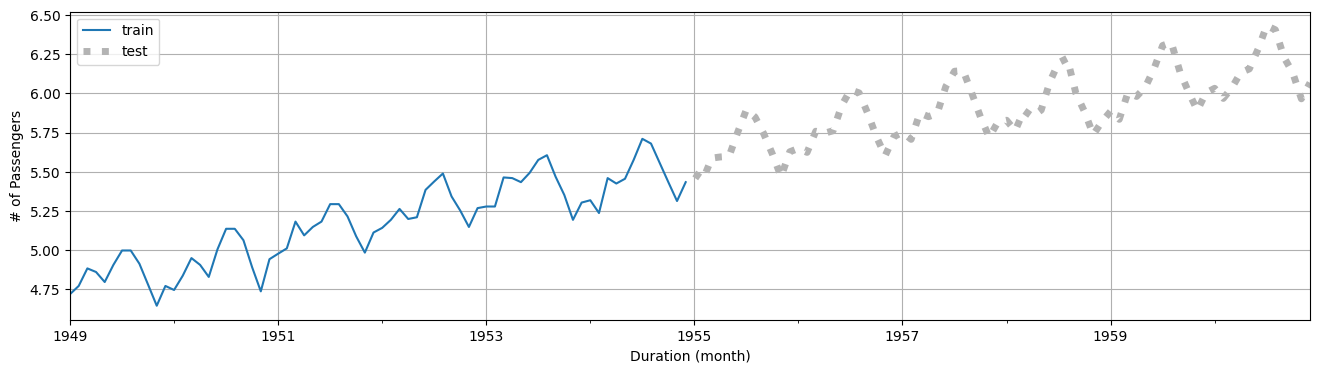

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# 学習データとテストデータに分割
from sklearn.model_selection import train_test_split
train_size = 0.5
train, test = train_test_split(data_log, train_size=train_size, shuffle=False)

ax1 = train.plot(label='train', figsize=(16,4))
test.plot(label='test',
            color="0.7",
            linestyle='dotted',
            linewidth="5.0",
            ax=ax1)
plt.xlabel('Duration (month)')
plt.ylabel('# of Passengers')
ax1.legend(['train', 'test'])
plt.grid(True)
plt.show()

# <font color="DarkOrange">1. AR（自己回帰モデル）</font>
AR(Autoregressive)モデルは、3章でご紹介した自己相関を用いて時系列データをモデリングする手法です。
データが過去の値に依存するパターンを持つ場合に特に有効な手法です。

モデル構築を行う際に、どれだけズレた時刻の情報を用いるのか指定する必要があります。前章の自己相関の解析で12ヶ月前の値がもっとも相関していることになっているので、$lags = 12$をパラメータとして指定します。


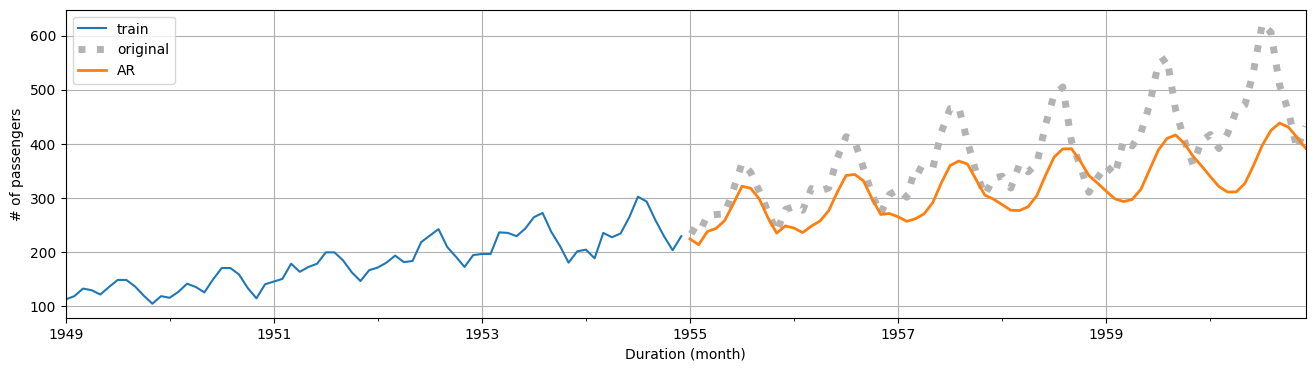

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

# fit AR model
ar = AutoReg(train, lags=12).fit()

st = test.index.to_timestamp()[0]
ed = test.index.to_timestamp()[-1]

ar_pred = ar.predict(st, ed)

# データは対数変換されていると仮定し、元のスケールに戻すために指数変換（exp）を適用する
ax1 = np.exp(train).plot(figsize=(16,4))
np.exp(test).plot(color='0.7', linestyle='dotted', linewidth='5.0', ax=ax1)
np.exp(ar_pred).plot(linewidth='2.0', ax=ax1)

plt.legend(['train', 'original', 'AR'])
plt.xlabel('Duration (month)')
plt.ylabel('# of passengers')
plt.grid(True)
plt.show()

# <font color="DarkOrange">2. MA（移動平均モデル）</font>
MA（Moving Average）モデルはより簡単で、データから特定のウインドウサイズで移動平均値を取得し、それによりモデル化するものです。

ARモデル（自己回帰モデル）は、過去の値（データそのもの）を使って現在の値を予測するのに対し、MAモデルは、過去の誤差（予測のズレ）を使って現在の値を予測します。

例）例えば、ある商品の需要を予測するとします。
昨日の需要は「100個」でしたが、予測では「90個」となり、予測誤差は「+10個」でした。
一昨日の需要は「95個」でしたが、予測では「85個」となり、予測誤差は「+10個」でした。
MAモデルは、このような**過去の誤差（+10個や-5個など）**を使って、明日の需要を予測します。「過去の予測のズレを反映するモデル」と覚えると分かりやすいでしょう。

ここでは、6ヶ月の移動平均値を用いて予測を行います。


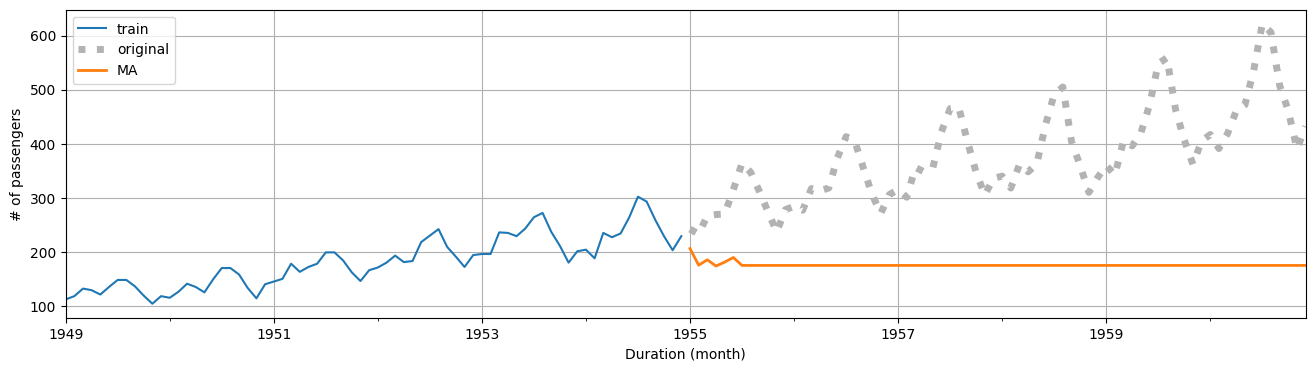

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit MA model
ma = ARIMA(train, order=(0, 0, 6)).fit()

st = test.index.to_timestamp()[0]
ed = test.index.to_timestamp()[-1]

ma_pred = ma.predict(st, ed)

ax1 = np.exp(train).plot(figsize=(16,4))
np.exp(test).plot(color='0.7', linestyle='dotted', linewidth='5.0', ax=ax1)
np.exp(ma_pred).plot(linewidth='2.0', ax=ax1)

plt.legend(['train', 'original', 'MA'])
plt.xlabel('Duration (month)')
plt.ylabel('# of passengers')
plt.grid(True)
plt.show()

# <font color="DarkOrange">3. ARMA（自己回帰移動平均モデル）</font>
ARMAモデル（Autoregressive Moving Average Model）は、時系列データを過去の値（自己回帰部分, AR）と過去の誤差（移動平均部分, MA）の両方を使って予測するモデルです。

時系列データは複雑で、単純なARモデルやMAモデルだけでは正確な予測が難しい場合があります。
ARMAモデルでは、それぞれの長所を組み合わせて、データの特徴をより正確に捉えることができます。

ARMAモデルは、自己回帰成分（AR）と移動平均成分（MA）を両方持つモデルです。

つまり、自己回帰パラメータp、階差パラメータd（ARMAモデルでは差分を取らないため0とします）、移動平均パラメータqの3つのパラメータがあり、ARIMA(p, 0, q)という風に表現します。

ここでは、ARのパラメータを10（ヶ月）、階差のパラメータを0、MAのパラメータを6として予測してみます。

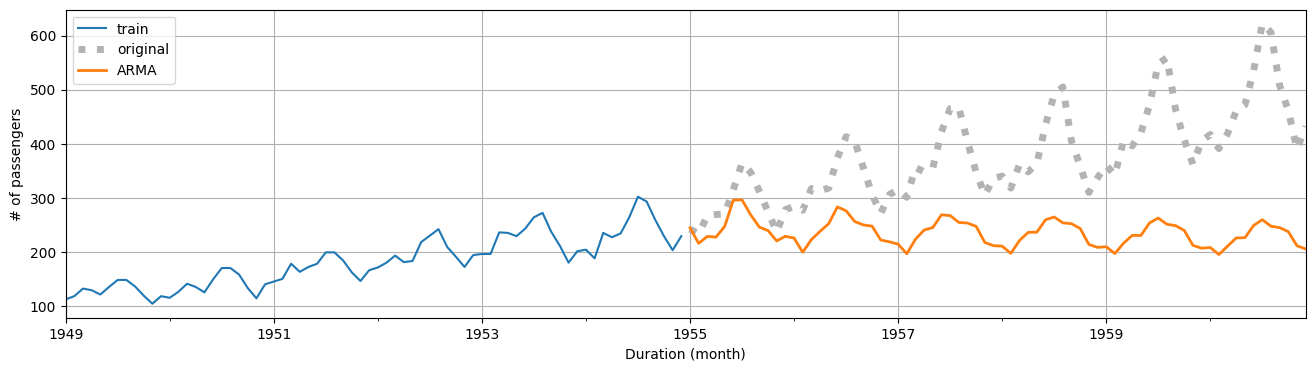

In [ ]:
# fit ARMA model (p=10, d=0, q=6)
arma = ARIMA(train, order=(10, 0, 6)).fit()

st = test.index.to_timestamp()[0]
ed = test.index.to_timestamp()[-1]

arma_pred = arma.predict(start=st, end=ed)

ax1 = np.exp(train).plot(figsize=(16, 4))
np.exp(test).plot(color='0.7', linestyle='dotted', linewidth='5.0', ax=ax1)
np.exp(arma_pred).plot(linewidth='2.0', ax=ax1)

plt.legend(['train', 'original', 'ARMA'])
plt.xlabel('Duration (month)')
plt.ylabel('# of passengers')
plt.grid(True)
plt.show()


# <font color="DarkOrange">4. ARIMA（自己回帰差分移動平均モデル）</font>
ARIMA(Auto Regressive Integrated Moving Average)モデルは、上記で示したAR、階差、MAの情報を用いて時系列データをモデリングする手法であり、それぞれに関するパラメータを持ちます。

ARIMAは以下の3つの要素で構成されます：
- AR（自己回帰）:<br>
過去の値（ラグ）を使って現在の値を予測。
- I（差分）:<br>
データを定常化するために、差分を取ってトレンドや季節性を除去。
- MA（移動平均）:<br>
過去の誤差（予測ズレ）を使って現在の値を予測。

ARMA = AR（AR過程）+ I（和分過程）+ MA（MA過程）と表すことができます。

つまり、自己回帰パラメータp、階差パラメータd、移動平均パラメータqの3つのパラメータがあり、ARIMA(p, d, q)という風に表現します。



ここではARのパラメータを12（ヶ月）、階差のパラメータを2、MAのパラメータを6として予測してみます。

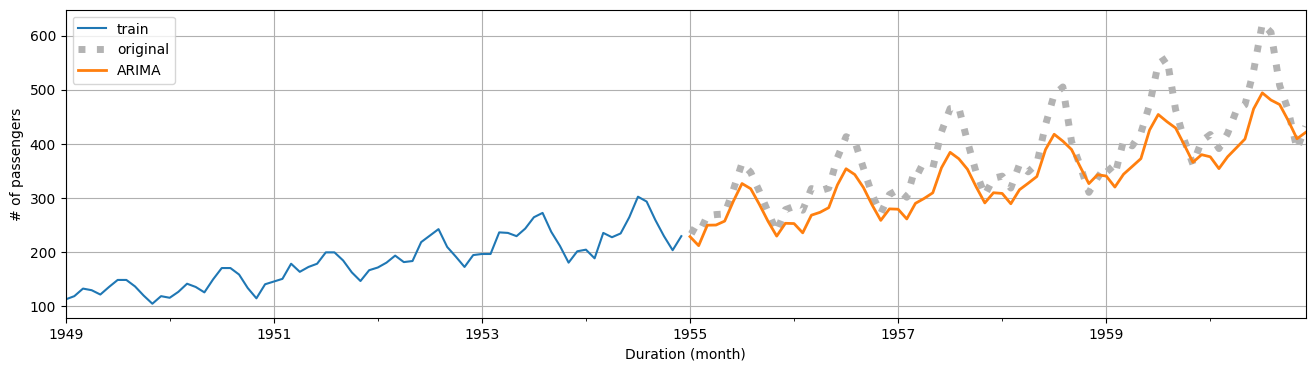

In [ ]:
# fit ARIMA model (p=12, d=2, q=6)
arima= ARIMA(train, order=(12, 2, 6)).fit()

st = test.index.to_timestamp()[0]
ed = test.index.to_timestamp()[-1]

arima_pred = arima.predict(st, ed)

ax1 = np.exp(train).plot(figsize=(16,4))
np.exp(test).plot(color='0.7', linestyle='dotted', linewidth='5.0', ax=ax1)
np.exp(arima_pred).plot(linewidth='2.0', ax=ax1)

plt.legend(['train', 'original', 'ARIMA'])
plt.xlabel('Duration (month)')
plt.ylabel('# of passengers')
plt.grid(True)
plt.show()

# <font color="DarkOrange">5. まとめ</font>
本章では時系列解析の基本モデルを学びました。それぞれの比較表を以下にまとめます。<br>それぞれのモデルの特性を理解しメリットやデメリットを考慮した上で最適なモデルを選択してください。

| **モデル** | **メリット** | **デメリット** | **用途** | **向いているデータ** |
| :---: | :---: | :---: | :---: | :---: |
| AR | 過去のデータを使ってシンプルに予測可能 | トレンドや季節性があるデータには対応できない | 短期的な需要予測、価格や売上の予測 | データに自己相関が強く、定常性を持つもの |
| MA | 過去の誤差（ノイズ）の影響を補正できる | 多くの誤差項を考慮する場合、モデルが複雑化 | ノイズ除去、短期的な変動予測 | 定常性を持ち、トレンドが少なく、短期的変動が特徴的なもの |
| ARMA | ARとMAの長所を組み合わせることで、自己相関と誤差を同時に考慮可能 | トレンドや季節性があるデータには対応できない、データに定常性が必要 | 短期的な予測、経済や金融市場の短期変動の分析 | 定常性を持つデータ、トレンドや季節性が除去済みのデータ |
| ARIMA | トレンドや季節性を含む非定常データに対応可能、時系列解析の基本モデルで広く応用される | モデルの構築に手間がかかる（差分、次数の選択など）、計算量が多く複雑、モデルが過学習しやすい | トレンドや季節性が強いデータの予測、気温、売上、経済指標などの予測 | トレンドや季節性を含む非定常データ |